Best parameters:
x: 7.7775121458576

Best target value:
1.0617094937373863


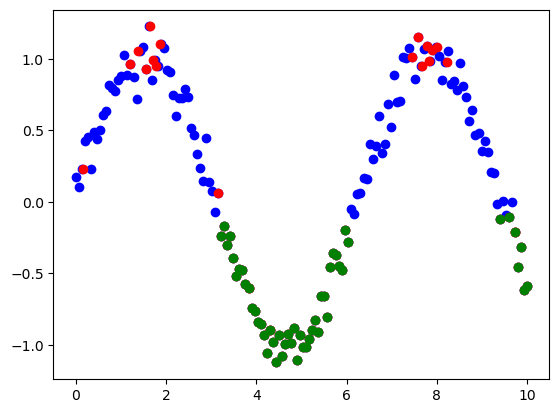

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from IPython.display import clear_output

np.random.seed(0)

# Step 1: Generate synthetic dataset of a sine wave with noise
np.random.seed(0)
n = 150
x = np.linspace(0, 10, n)
y = np.sin(x) + np.random.normal(0, 0.1, n)
data = pd.DataFrame({'x': x, 'y': y})

# Step 2: Index out the bottom 10 points to train off of 
df = data.nsmallest(50, 'y')
initial = df
df.to_csv('synthetic_data_sampled.csv', index=False)

# Step 3: Setup the Ax optimization client
ax_client = AxClient()

# Define the parameters based on your synthetic data
parameters = [
    {"name": "x", "type": "range", "bounds": [0.0, 10.0]}
]

# Create the experiment
ax_client.create_experiment(
    name="synthetic_experiment",
    parameters=parameters,
    objectives={"y": ObjectiveProperties(minimize=False)},
)

# Attach existing trials from the bottom 10 points
index = 0
for i, row in df.iterrows():
    parameters = {"x": row["x"]}
    objective_value = row['y']
    ax_client.attach_trial(parameters)
    ax_client.complete_trial(trial_index=index, raw_data={"y": objective_value})
    index += 1

for j in range(20):
    df = pd.read_csv('synthetic_data_sampled.csv')

    # Get next set of parameters to try
    parameters, trial_index = ax_client.get_next_trial()

    # Print the parameters
    print("Next parameters to try:")
    for key, value in parameters.items():
        print(f"{key}: {value}")

    # Here you would typically run your experiment with these parameters
    # and get a result. For this example, let's just use a dummy result
    # set the result as the y value that best matches the x value suggested using euclidian distance 
    result = data.loc[(data['x'] - parameters['x']).abs().argsort()[:1]]['y'].values[0]

    # Complete the trial with the result
    ax_client.complete_trial(trial_index=trial_index, raw_data={"y": result})

    # Append the new trial to the dataframe
    new_row = pd.DataFrame(parameters, index=[trial_index])
    new_row['y'] = result
    df = pd.concat([df, new_row], ignore_index=True)

    df.describe()

    # Save the updated dataframe to a CSV file
    df.to_csv('synthetic_data_sampled.csv', index=False)

# Get the best parameters
best_parameters, metrics = ax_client.get_best_parameters()

clear_output(wait=True)

# Print the best parameters
print("Best parameters:")
for key, value in best_parameters.items():
    print(f"{key}: {value}")

print("\nBest target value:")
print(metrics[0]['y'])

plt.scatter(x, y, color='blue')
plt.scatter(df['x'], df['y'], color='red')
plt.scatter(initial ['x'], initial['y'], color='green')
plt.show()